In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
start_time = time.time()

In [2]:
data_raw = pd.read_csv('ratings.csv')
movie2index = {} # {movieId: index}
index2movie = {} # {index: movieId}
for index, movieId in enumerate(data_raw['movieId'].unique()):
    movie2index[movieId] = index
    index2movie[index] = movieId

In [3]:
def data_preprocess(data_path:str)->pd.DataFrame:
    """
    数据预处理
    :param data_path: 数据路径
    :return: 处理后的数据
    """
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [4]:
data_raw = data_preprocess("ratings.csv")

In [5]:
data_raw

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


In [6]:
def get_data_matrix(data:list[list], user_num:int, movie_num:int)->np.ndarray:
    """
    获取数据矩阵
    :param data: 数据
    :param user_num: 用户数量
    :param movie_num: 电影数量
    """
    
    data_matrix = np.zeros((user_num, movie_num))
    for record in data:
        user = int(record[0])   # 用户名
        movieId = int(record[1])  # 电影
        movie = movie2index[movieId] 
        rating = record[2]      # 评分
        data_matrix[user-1, movie] = rating
    return data_matrix

In [7]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[np.ndarray, np.ndarray]:
    """
    k折交叉验证
    :param data: 数据
    :param k: 折数
    :return: 训练集和验证集
    """
    user_num, movie_num = data_raw['userId'].max(), data_raw['movieId'].nunique()
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        # print(f"第{i+1}折: 训练集长度为{len(train)}, 验证集长度为{len(valid)}")
        yield get_data_matrix(train,user_num,movie_num), get_data_matrix(valid,user_num,movie_num)

In [8]:
# print(" train_len   valid_len")
for train_matrix, val_matrix in k_folds(data_raw):
    print(train_matrix.shape, val_matrix.shape)


(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)


In [9]:
def Pearson(rating_a, rating_b):
    """
    计算皮尔逊相关系数
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 皮尔逊相关系数
    """
    temp_a = rating_a - np.mean(rating_a)
    temp_b = rating_b - np.mean(rating_b)
    numerator = np.sum(temp_a * temp_b)
    denominator = np.sqrt(np.sum(temp_a ** 2)) * np.sqrt(np.sum(temp_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [10]:
def Cosine(rating_a, rating_b):
    """
    计算余弦相似度
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 余弦相似度
    """
    numerator = np.sum(rating_a * rating_b)
    denominator = np.sqrt(np.sum(rating_a ** 2)) * np.sqrt(np.sum(rating_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [11]:
def Slope_One(rating_a, rating_b):
    """
    计算Slope One相似度
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: Slope One相似度
    """
    numerator = np.sum(rating_a - rating_b)
    denominator = len(rating_a)
    return numerator / denominator if denominator != 0 else np.nan

In [12]:
def DSS(rating_a, rating_b, threshold=0.0):
    """
    计算DSS相似度
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: DSS相似度
    """
    similarity = Pearson(rating_a, rating_b)    # 皮尔逊相似度
    if similarity > threshold and similarity != np.nan:  # 如果皮尔逊相似度大于阈值
         return Slope_One(rating_a, rating_b)   # 返回Slope One相似度
    else:
        return np.nan   # 否则返回nan

In [13]:
from typing import Callable, Optional
def calculate_similarity(train_matrix:np.ndarray, sim_func:Callable=Pearson, threshold:Optional[float]=None)->np.ndarray:
    """
    计算皮尔逊相关系数
    :param train_matrix: 训练集矩阵
    :sim_func: 相似度函数
    :threshold: 阈值(仅当使用DSS计算相似度时使用)
    :return: 皮尔逊相关系数矩阵
    """
    n_users, n_movies = train_matrix.shape # 用户数和电影数
    sim_matrix = np.full((n_users, n_users), np.nan) # 初始化皮尔逊相关系数矩阵

    # 获取每个用户看过的电影
    seen_movies = {}
    for user in range(n_users):
        seen_movies[user] = np.flatnonzero(train_matrix[user])

    for user_a in range(n_users):
        for user_b in range(n_users):
            if user_a <= user_b:    # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = np.intersect1d(seen_movies[user_a], seen_movies[user_b], assume_unique=True)

            # 如果交集为空，跳过
            if len(intersection_movies) == 0:   
                continue

            rating_a = train_matrix[user_a][intersection_movies]    # 用户a的交集电影评分
            rating_b = train_matrix[user_b][intersection_movies]    # 用户b的交集电影评分
            
            # 计算相似度
            if sim_func == Cosine or sim_func == Pearson:
                sim_matrix[user_a][user_b] = sim_matrix[user_b][user_a] = sim_func(rating_a, rating_b)
            else:
                if sim_func == DSS:
                    sim = sim_func(rating_a, rating_b, threshold)
                elif sim_func == Slope_One:
                    sim = sim_func(rating_a, rating_b)
                sim_matrix[user_a][user_b] = sim
                sim_matrix[user_b][user_a] = -sim

    return sim_matrix


In [14]:
for train_matrix, val_matrix in k_folds(data_raw):
    train_matrix =train_matrix
    val_matrix = val_matrix
    break

In [15]:
DSS_matrix = calculate_similarity(train_matrix,sim_func=DSS, threshold=0.0)

In [16]:
DSS_matrix[0]

array([        nan,         nan,  2.5       ,  0.86486486,  0.36363636,
               nan,         nan,  0.41666667, -0.25      ,         nan,
               nan,         nan,  0.5       ,  0.75      ,  0.47368421,
        1.15      ,  0.078125  ,  0.55      ,  1.12      ,  0.69565217,
        0.5       ,         nan,         nan,  0.05555556,         nan,
        0.42857143,  0.61764706,         nan,         nan,         nan,
               nan,  0.36842105,  0.38095238,  0.58333333,         nan,
        1.8125    ,         nan,  0.41176471,         nan,         nan,
               nan,  0.51666667, -0.47058824,  0.66666667,  0.15060241,
       -0.2       ,  1.61111111,         nan,  0.08333333,  0.94117647,
        0.90909091,         nan,         nan,         nan,  2.25      ,
        0.11111111,  0.80232558, -0.04545455,  0.58823529,         nan,
        0.3       , -0.        ,  0.7972973 ,  0.5       ,  0.5       ,
        0.47222222,         nan,         nan, -0.25      ,      

In [17]:
def sort_neighbor(sim_matrix:np.ndarray, sim_func:Callable=Pearson)->dict:
    """
    获取潜在相邻用户
    :param pcc_matrix: 皮尔逊相关系数矩阵
    :return: 相邻用户矩阵
    """
    n_users = sim_matrix.shape[0]
    neighbor_dict = {}
    if sim_func == Cosine or sim_func == Pearson:
        for user in range(n_users):
            sorted_arr = np.argsort(sim_matrix[user])[::-1] # 降序排列
            sorted_arr = sorted_arr[np.isnan(sim_matrix[user][sorted_arr]) == False]    # 去掉nan
            neighbor_dict[user] = sorted_arr
    elif sim_func == DSS or sim_func == Slope_One:
        for user in range(n_users):
            # 获取不是nan的索引
            neighbor_dict[user] = np.where(np.isnan(sim_matrix[user]) == False)[0]
    return neighbor_dict

In [18]:
neighbors_dict = sort_neighbor(DSS_matrix, sim_func=DSS)

In [19]:
DSS_matrix[0][neighbors_dict[0]]

array([ 2.5       ,  0.86486486,  0.36363636,  0.41666667, -0.25      ,
        0.5       ,  0.75      ,  0.47368421,  1.15      ,  0.078125  ,
        0.55      ,  1.12      ,  0.69565217,  0.5       ,  0.05555556,
        0.42857143,  0.61764706,  0.36842105,  0.38095238,  0.58333333,
        1.8125    ,  0.41176471,  0.51666667, -0.47058824,  0.66666667,
        0.15060241, -0.2       ,  1.61111111,  0.08333333,  0.94117647,
        0.90909091,  2.25      ,  0.11111111,  0.80232558, -0.04545455,
        0.58823529,  0.3       , -0.        ,  0.7972973 ,  0.5       ,
        0.5       ,  0.47222222, -0.25      ,  0.07894737,  1.46153846,
        1.25925926,  0.65625   , -0.04166667,  0.69512195,  0.76666667,
        0.47222222,  0.3125    ,  2.84615385,  0.2       ,  0.51086957,
       -0.51612903,  0.11538462,  0.36666667, -0.28571429,  0.39130435,
        0.42708333,  1.27586207,  0.18965517, -1.25      , -0.        ,
        0.5       ,  1.09615385, -0.06666667,  0.33333333,  1.25

In [20]:
def avg(train_matrix:np.ndarray)->np.ndarray:
    """
    计算每个用户的平均评分
    :param train_matrix: 训练集矩阵
    :return: 每个用户的平均评分
    """
    n_users, n_movies = train_matrix.shape
    avg_array = np.full(n_users, 3.5)   # 初始化为3.5
    for user in range(n_users):
        avg_array[user] = np.mean(train_matrix[user][train_matrix[user] != 0])
    return avg_array

In [21]:
avg_array = avg(train_matrix)
avg_array[:10]

array([4.33333333, 3.92592593, 2.52941176, 3.51269036, 3.62790698,
       3.49462366, 3.25954198, 3.68421053, 3.28888889, 3.2375    ])

In [22]:
def predict(train_matrix:np.ndarray, valid_matrix:np.ndarray, 
            sim_matrix:np.ndarray, avg_array:np.ndarray, 
            neighbors_dict:dict, neighbor_num:Optional[int]=None,
            sim_func:Callable=Pearson)->np.ndarray:
    """
    预测用户对电影的评分
    :param train_matrix: 训练集矩阵
    :param valid_matrix: 验证集矩阵
    :param sim_matrix: 相似度矩阵
    :param avg_array: 每个用户的平均评分
    :param neighbors_dict: 相邻用户字典
    :param neighbor_num: 相邻用户的个数(仅在使用Pearson或Cosine时使用; 若使用Slope One或DSS, 可以传入但不会被使用)
    :param sim_func: 相似度计算方法
    :return: 预测矩阵
    """
    pred_matrix = np.zeros(valid_matrix.shape)
    # neighbor_used = [] # 记录预测每部电影时使用的相邻用户的个数
    
    for user in range(pred_matrix.shape[0]):
        to_predict_movies = np.flatnonzero(valid_matrix[user])  # 需要预测的电影
        neighbors = neighbors_dict[user]    # 潜在相邻用户
        for movie in to_predict_movies: # 遍历每个需要预测的电影
            numerator = 0
            denominator = 0
            neighbors_now = 0 # 记录当前使用的相邻用户的个数
            for neighbor in neighbors:  # 遍历每个潜在相邻用户
                if train_matrix[neighbor, movie] == 0:  # 如果相邻用户没有评价过该电影，则跳过
                    continue
                
                neighbors_now += 1
                # 使用Pearson或Cosine
                if sim_func == Pearson or sim_func == Cosine:   
                    numerator += sim_matrix[user, neighbor] * (train_matrix[neighbor, movie] - avg_array[neighbor])
                    denominator += abs(sim_matrix[user, neighbor])
                    if neighbors_now >= neighbor_num:  # 如果已使用的邻居数量已达到要求，则跳出循环
                        break
                # 使用DSS或Slope One
                elif sim_func == DSS or sim_func == Slope_One:
                    numerator += train_matrix[neighbor, movie] + sim_matrix[user, neighbor]

            # 使用Pearson或Cosine
            if sim_func == Pearson or sim_func == Cosine:
                pred_matrix[user, movie] = avg_array[user] + numerator / denominator if denominator != 0 else avg_array[user]
            # 使用DSS或Slope One
            elif sim_func == DSS or sim_func == Slope_One:
                pred_matrix[user, movie] = numerator / neighbors_now if neighbors_now != 0 else avg_array[user]

    return pred_matrix

In [23]:
predict_matrix = predict(train_matrix, val_matrix, DSS_matrix, avg_array, neighbors_dict, sim_func=DSS)

In [24]:
def MAE(predict_matrix:np.ndarray, valid_matrix:np.ndarray)->float:
    """
    计算MAE
    :param predict_matrix: 预测矩阵
    :param valid_matrix: 验证集矩阵
    :return: MAE
    """
    # 找到非零元素的索引
    nonzero_indices = np.nonzero(valid_matrix)
    # 计算MAE
    mae = np.mean(np.abs(valid_matrix[nonzero_indices] - predict_matrix[nonzero_indices]))
    return mae

In [25]:
MAE(predict_matrix, val_matrix)

0.6691510614357226

In [26]:
def user_based_CF(data_path:str, fold_num:int, 
                  neighbor_num:Optional[int]=None, sim_func:Callable=Pearson, 
                  threshold:Optional[float]= None, log:bool=True)->float:
    """
    基于用户的协同过滤
    :param data_path: 数据路径
    :param fold_num: 折数
    :param neighbor_num: 相邻用户的个数 (仅在使用Pearson或Cosine时使用)
    :param sim_func: 相似度计算方法
    :param threshold: 阈值 (仅在使用DSS时传入)
    :param log: 是否打印日志
    :return: 预测矩阵，验证集矩阵，用户的平均评分 * 折数
    """

    data_raw = data_preprocess(data_path)
    
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        # 计算相似度
        sim_matrix = calculate_similarity(train_matrix, sim_func=sim_func, threshold=threshold)
        # 对相似度字典进行排序
        neighbors_dict = sort_neighbor(sim_matrix, sim_func=sim_func)
        # 计算每个用户的平均评分
        avg_array = avg(train_matrix)
        # 预测
        predict_matrix = predict(train_matrix, val_matrix, 
                                 sim_matrix, avg_array, neighbors_dict, 
                                 neighbor_num=neighbor_num, sim_func=sim_func)
        if log:
            print(f"第{i+1}折")
        yield predict_matrix, val_matrix, avg_array

In [27]:
print(DSS.__name__)
maes = []
for predict_matrix, val_matrix, _ in user_based_CF("ratings.csv", 10, sim_func=DSS, threshold=0.0):
    maes.append(MAE(predict_matrix, val_matrix))
    print(maes[-1])
print(f"平均MAE: {np.mean(maes)}")

DSS
第1折
0.6691510614357226
第2折
0.6579662681891139
第3折
0.6535200745157662
第4折
0.6636172382639705
第5折
0.664655781727048
第6折
0.6512357035784653
第7折
0.659213771048218
第8折
0.6590129849428461
第9折
0.6631965772087679
第10折
0.6667237229646553
平均MAE: 0.6608293183874574


In [28]:
from Observation import Observation_of_prediction
from typing import Callable, Optional
def get_all_observations(data_path:str, neighbor_nums:list[int], 
                         fold_num:int=10, sim_func:Callable=Pearson, 
                         threshold:Optional[float]=None, log=True)->list[Observation_of_prediction]:
    """
    获取不同邻居下的所有预测值
    :param data_path: 数据路径
    :param neighbor_nums: 相邻用户个数list(在使用Pearson或Cosine时使用, 若使用其他方法, 也需要传入但不会被使用)
    :param fold_num: 折数
    :param sim_func: 相似度计算方法
    :param threshold: 阈值(仅在使用DSS时传入, 使用其他方法时不要传入)
    :return: 所有预测值
    """
    print(sim_func.__name__)

    data_raw = data_preprocess(data_path)
    # k折验证
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        observation_list = []
        if log:
            print(f"第{i+1}折")
        sim_matrix = calculate_similarity(train_matrix, sim_func=sim_func, threshold=threshold)
        neighbors_dict = sort_neighbor(sim_matrix, sim_func=sim_func)
        avg_array = avg(train_matrix)
        # 不同的邻居个数
        for neighbor_num in neighbor_nums:
            if log:
                print(f"邻居个数: {neighbor_num}")
            # 预测
            predict_matrix = predict(train_matrix, val_matrix, sim_matrix, avg_array, neighbors_dict, neighbor_num=neighbor_num, sim_func=sim_func)
            # 找到非零元素的索引
            nonzero_indices = np.nonzero(val_matrix)
            # 将每个预测值保存到列表中
            for user, item in zip(nonzero_indices[0], nonzero_indices[1]):
                userId = user + 1
                movieId = index2movie[item]
                observation_list.append(Observation_of_prediction(userId, movieId, neighbor_num, predict_matrix[user, item], val_matrix[user, item], avg_array[user]))

        yield observation_list

In [29]:
neighbor_nums = [i for i in range(1,10)] + [i for i in range(10, 25, 3)] + [i for i in range(25, 101, 5)]
for group in get_all_observations("ratings.csv", neighbor_nums, fold_num=10, sim_func=DSS, threshold=0.0):
    observation_list_all = group
    break
# observation_list_all = get_all_observations("ratings.csv", neighbor_nums, fold_num=10, sim_func=DSS, threshold=0.0)

DSS
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100


In [30]:
from itertools import groupby
from Error import Error

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    error = Error(list(group))
    print(f"邻居个数: {neighbor_num}, MAE: {error.MAE()}, RMSE: {error.RMSE()}")

邻居个数: 1, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 2, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 3, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 4, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 5, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 6, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 7, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 8, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 9, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 10, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 13, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 16, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 19, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 22, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 25, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 30, MAE: 0.6691510614357226, RMSE: 0.8824023000018674
邻居个数: 35, MAE: 0.6691510614357226, RMSE: 0.882402

In [31]:
from Metric import Metric, Count, Positive_or_negative
from itertools import groupby

observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    metric = Metric(list(group))
    print(metric.accuracy(), metric.precision(), metric.recall(), metric.f1())

0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162947535 0.6699825479930192 0.7067378497790869 0.6878695574269844
0.6544679162

In [32]:
from itertools import groupby
from Ranking import RankingPerformance

ranking_list_all = {}  # {neighbor_num: {user: ranking list}}
observation_list_all.sort(key=lambda x: x.neighbors)
for neighbor_num, group in groupby(observation_list_all, key=lambda x: x.neighbors):
    group_list = list(group)
    # print(len(group_list))
    ranking = RankingPerformance(group_list)
    print(ranking.HLU(h=2), ranking.NDCG(b=2))
    ranking_list_all[neighbor_num] = ranking.ranking_list_dict

0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0.983628258142205 0.6985149866392731
0

In [33]:
print(ranking_list_all[1][1])   # 在邻居数量为1时，1号用户的预测列表和实际列表

user:1	neighbor:1	avg:4.333333333333333
pred movie	pred rating			act rating			act movie	act rating
1198		4.8660556683285465		5.0				596		5.0
1927		4.727383089468807		5.0				1029		5.0
1278		4.663613878723015		5.0				1198		5.0
3740		4.662628688681505		4.0				1278		5.0
2078		4.613230136847908		5.0				1587		5.0
1954		4.593023173968666		5.0				1927		5.0
3578		4.558340462189163		5.0				1954		5.0
2529		4.491136301673904		5.0				2048		5.0
3034		4.4300491602858285		5.0				2078		5.0
2991		4.411754495294442		5.0				2115		5.0
2797		4.3363016794842935		4.0				2353		5.0
1500		4.328770379100863		4.0				2387		5.0
2115		4.291909020518475		5.0				2459		5.0
2899		4.257425742574258		5.0				2529		5.0
2640		4.241486888098722		4.0				2899		5.0
2387		4.198779673032927		5.0				2991		5.0
2048		4.155433722603372		5.0				3034		5.0
596		4.155219240299463		5.0				3578		5.0
1029		4.119282805699522		5.0				1500		4.0
1587		4.10906743937702		5.0				2492		4.0
1580		4.0582873949384055		3.0				2640		4.0
2353		3.9497491997

In [34]:
fold_num = 10
neighbor_nums = [i for i in range(1,10)] + [i for i in range(10, 25, 3)] + [i for i in range(25, 101, 5)]
data_path = "ratings.csv"

In [35]:
from itertools import groupby
from Error import Error
from Metric import Metric
from Ranking import RankingPerformance

def get_evaluations(data_path:str, neighbor_nums:list[int], 
                    fold_num:int=10, sim_func:Callable=Pearson, 
                    threshold:Optional[float]=None, log:bool=True)->dict:
    """
    :param data_path: 数据路径
    :param neighbor_nums: 相邻用户个数list(在使用Pearson或Cosine时使用, 若使用其他方法, 也需要传入但不会被使用)
    :param fold_num: 折数
    :param sim_func: 相似度计算方法
    :param threshold: 阈值(仅在使用DSS时需要传入, 使用其他方法时不要传入)
    :param log: 是否打印日志
    :return: 所有评估指标
    """
    # 创建一个字典来存储所有的评估指标
    evaluations = {
        'MAE': [0] * len(neighbor_nums),
        'RMSE': [0] * len(neighbor_nums),
        'accuracy': [0] * len(neighbor_nums),
        'precision': [0] * len(neighbor_nums),
        'recall': [0] * len(neighbor_nums),
        'f1': [0] * len(neighbor_nums),
        'HLU': [0] * len(neighbor_nums),
        'NDCG': [0] * len(neighbor_nums)
    }

    for observation_list in get_all_observations(data_path, neighbor_nums, fold_num=10, sim_func=sim_func, threshold=threshold, log=log):
        # observation_list: 每个折的所有预测值组成的列表
        observation_list.sort(key=lambda x: x.neighbors)
        for i, (neighbor_num, group) in enumerate(groupby(observation_list, key=lambda x: x.neighbors)):
            # group: 每个邻居个数的所有预测值组成的列表
            """
            错误的写法：
            error = Error(list(group))      
            metric = Metric(list(group))    
            ranking = RankingPerformance(list(group), h=2, b=2)

            `groupby`函数返回的`group`是一个迭代器。
            当你第一次调用`list(group)`时，迭代器会遍历所有的元素并返回一个列表。
            然后，当你再次调用`list(group)`时，由于迭代器已经遍历过所有的元素，所以它不会返回任何元素，结果就是一个空列表。
            你可以通过将`group`转换为列表并将其存储在一个变量中来解决这个问题，然后在后续的代码中使用这个变量。
            这样，你就可以多次使用这个列表而不会遇到迭代器已经耗尽的问题。
            """
            group_list = list(group)
            error = Error(group_list)
            metric = Metric(group_list)
            ranking = RankingPerformance(group_list)

            evaluations['MAE'][i] += error.MAE()
            evaluations['RMSE'][i] += error.RMSE()
            evaluations['accuracy'][i] += metric.accuracy()
            evaluations['precision'][i] += metric.precision()
            evaluations['recall'][i] += metric.recall()
            evaluations['f1'][i] += metric.f1()
            evaluations['HLU'][i] += ranking.HLU(h=2)
            evaluations['NDCG'][i] += ranking.NDCG(b=2)
            
    # 除以折数
    for key in evaluations:
        evaluations[key] = [i / fold_num for i in evaluations[key]]

    return evaluations

In [36]:
evaluations_DSS = get_evaluations(data_path, neighbor_nums, fold_num=fold_num, sim_func=DSS, threshold=0.0)

DSS
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第2折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第3折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第4折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数:

In [37]:
evaluations_Pearson = get_evaluations(data_path, neighbor_nums, fold_num=10, sim_func=Pearson)

Pearson
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第2折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第3折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第4折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻

In [38]:
evaluations_Cosine = get_evaluations(data_path, neighbor_nums, fold_num=10, sim_func=Cosine)

Cosine
第1折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第2折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第3折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居个数: 65
邻居个数: 70
邻居个数: 75
邻居个数: 80
邻居个数: 85
邻居个数: 90
邻居个数: 95
邻居个数: 100
第4折
邻居个数: 1
邻居个数: 2
邻居个数: 3
邻居个数: 4
邻居个数: 5
邻居个数: 6
邻居个数: 7
邻居个数: 8
邻居个数: 9
邻居个数: 10
邻居个数: 13
邻居个数: 16
邻居个数: 19
邻居个数: 22
邻居个数: 25
邻居个数: 30
邻居个数: 35
邻居个数: 40
邻居个数: 45
邻居个数: 50
邻居个数: 55
邻居个数: 60
邻居

In [39]:
def plot(x:list, y:list[list], labels:list, xlabel, ylabel, title):
    for i in range(len(y)):
        plt.plot(x, y[i], marker='o', label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [40]:
method = ['DSS', 'Pearson', 'Cosine']

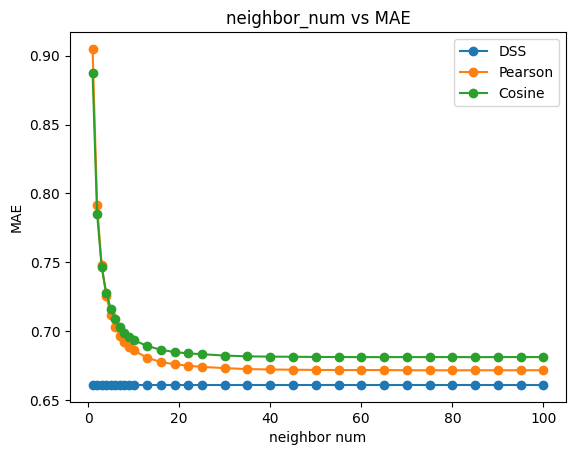

In [41]:
plot(neighbor_nums, [evaluations_DSS['MAE'], evaluations_Pearson['MAE'], evaluations_Cosine['MAE']], method, 'neighbor num', 'MAE', 'neighbor_num vs MAE')

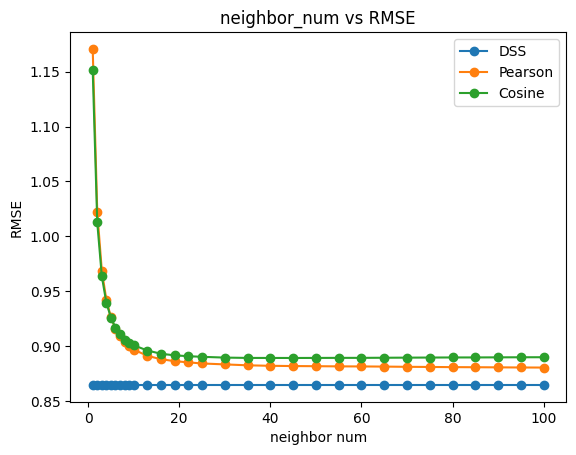

In [42]:
plot(neighbor_nums, [evaluations_DSS['RMSE'], evaluations_Pearson['RMSE'], evaluations_Cosine['RMSE']], method, 'neighbor num', 'RMSE', 'neighbor_num vs RMSE')

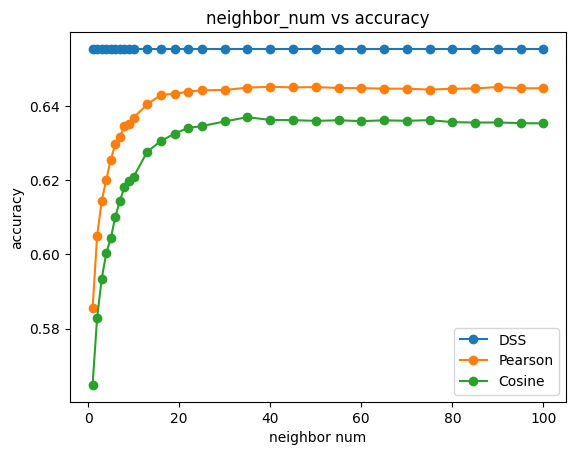

In [43]:
plot(neighbor_nums, [evaluations_DSS['accuracy'], evaluations_Pearson['accuracy'], evaluations_Cosine['accuracy']], method, 'neighbor num', 'accuracy', 'neighbor_num vs accuracy')

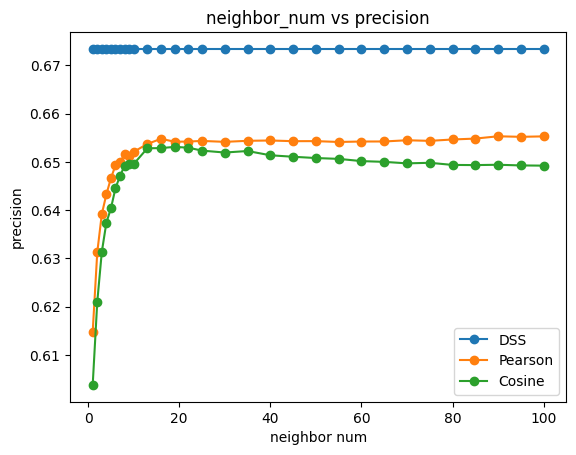

In [44]:
plot(neighbor_nums, [evaluations_DSS['precision'], evaluations_Pearson['precision'], evaluations_Cosine['precision']], method, 'neighbor num', 'precision', 'neighbor_num vs precision')

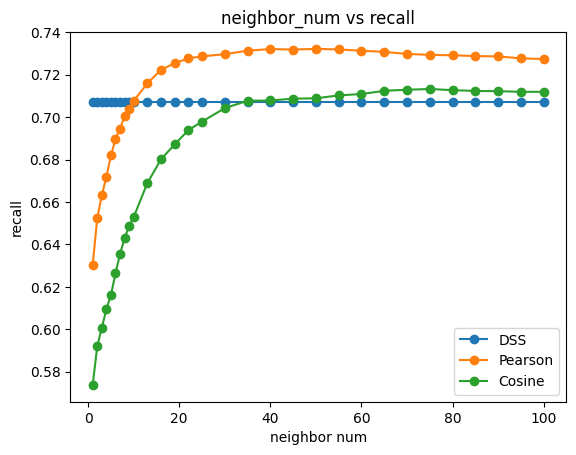

In [45]:
plot(neighbor_nums, [evaluations_DSS['recall'], evaluations_Pearson['recall'], evaluations_Cosine['recall']], method, 'neighbor num', 'recall', 'neighbor_num vs recall')

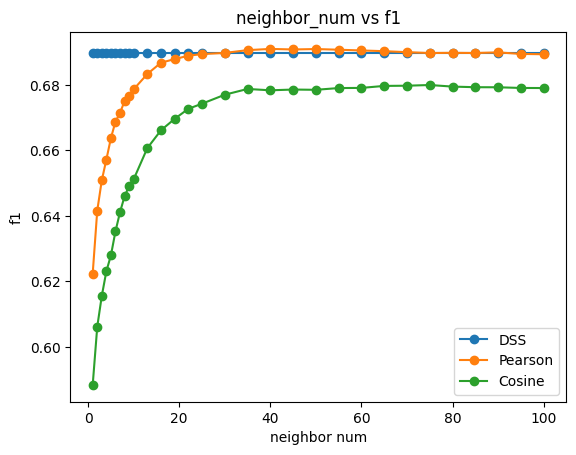

In [46]:
plot(neighbor_nums, [evaluations_DSS['f1'], evaluations_Pearson['f1'], evaluations_Cosine['f1']], method, 'neighbor num', 'f1', 'neighbor_num vs f1')

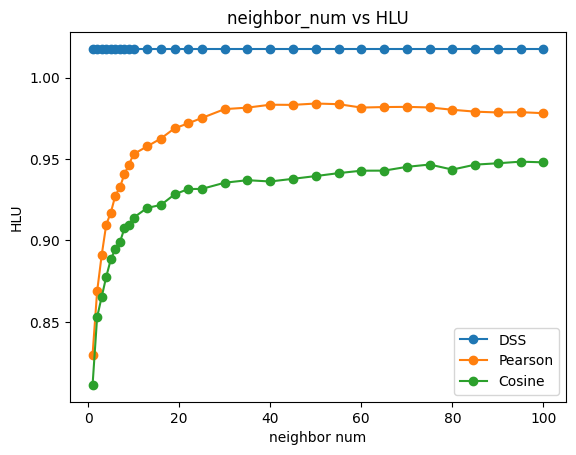

In [47]:
plot(neighbor_nums, [evaluations_DSS['HLU'], evaluations_Pearson['HLU'], evaluations_Cosine['HLU']], method, 'neighbor num', 'HLU', 'neighbor_num vs HLU')

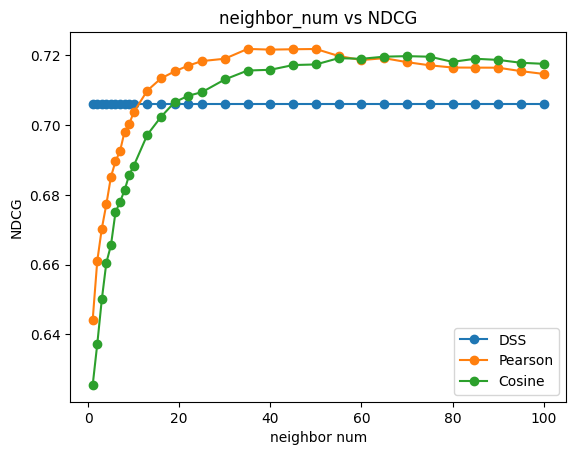

In [48]:
plot(neighbor_nums, [evaluations_DSS['NDCG'], evaluations_Pearson['NDCG'], evaluations_Cosine['NDCG']], method, 'neighbor num', 'NDCG', 'neighbor_num vs NDCG')

In [49]:
print(f"running time: {time.time() - start_time}s")

running time: 1355.2830460071564s
